## 1. Load raw data

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [3]:
df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")
df_weather = pd.read_csv("../data/raw/weather.csv")

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\1505384709.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")


# 2. Data cleaning

In [4]:
df_daily_rent_copy = df_daily_rent.copy()
df_weather_copy = df_weather.copy()

In [5]:
df_daily_rent_copy.shape

(16086672, 13)

In [6]:
# 1. Calculate amount & percent
check_nan = df_daily_rent_copy.isna().sum()
check_nan_percent = df_daily_rent_copy.isna().mean() * 100

# 2. Merge to data frame
# axis=1 merge by col
nan_summary = pd.concat([check_nan, check_nan_percent], axis=1)

# 3. Set col name
nan_summary.columns = ["count", "percent"]

# 4. Display if nan amount > 0
display(nan_summary[nan_summary["count"] > 0])

,count,percent
start_station_name,1450150,9.014605
start_station_id,1450150,9.014605
end_station_name,1558268,9.686702
end_station_id,1558917,9.690737
start_lat,10,0.000062
start_lng,10,0.000062
end_lat,25929,0.161183
end_lng,25929,0.161183


In [7]:
df_daily_rent_copy = df_daily_rent_copy.dropna()

In [8]:
# (optional) làm sạch tên cột để tránh dính space
df_daily_rent_copy.columns = df_daily_rent_copy.columns.astype(str).str.strip()

duplicate_count_started_at = df_daily_rent_copy.duplicated(subset=['started_at']).sum()

if 'ride_id' in df_daily_rent_copy.columns:
    duplicate_count_rider_id = df_daily_rent_copy.duplicated(subset=['ride_id']).sum()
else:
    duplicate_count_rider_id = None
    print("⚠️ 'ride_id' không tồn tại trong df_daily_rent_copy. Các cột hiện có:")
    print(df_daily_rent_copy.columns.tolist())

print(f"Số lượng dòng bị trùng theo started_at: {duplicate_count_started_at}")
print(f"Số lượng dòng bị trùng theo ride_id: {duplicate_count_rider_id}")
print(f"Tổng số dòng dữ liệu: {len(df_daily_rent_copy)}")


Số lượng dòng bị trùng theo started_at: 1119127
Số lượng dòng bị trùng theo ride_id: 94
Tổng số dòng dữ liệu: 13928217


In [9]:
df_daily_rent_copy = df_daily_rent_copy.drop_duplicates(subset=['ride_id'])

In [10]:
duplicate_count_rider_id = df_daily_rent_copy.duplicated(subset=['ride_id']).sum()
print(f"Số lượng dòng bị trùng theo ride_id sau khi loại bỏ: {duplicate_count_rider_id}")

df_daily_rent_copy.shape
print(f"Tổng số dòng dữ liệu: {len(df_daily_rent_copy)}")

Số lượng dòng bị trùng theo ride_id sau khi loại bỏ: 0
Tổng số dòng dữ liệu: 13928123


# 3. Data Integration

In [11]:
import pandas as pd

# 1. Trích xuất cột cần thiết
df_weather_needs = df_weather_copy[["datetime", "icon"]].copy()
df_daily_rent_needs = df_daily_rent_copy[["ride_id", "started_at"]].copy()

# 2. TẠO CỘT 'datetime' CHO BẢNG RENT 
# Chuyển đổi 'started_at' sang datetime, sau đó lấy phần ngày (YYYY-MM-DD) để khớp với file weather
df_daily_rent_needs['datetime'] = pd.to_datetime(df_daily_rent_needs['started_at'], format='mixed').dt.strftime('%Y-%m-%d')

# (Tùy chọn) Đảm bảo bảng Weather cũng chuẩn format string YYYY-MM-DD để so khớp chính xác
df_weather_needs['datetime'] = pd.to_datetime(df_weather_needs['datetime']).dt.strftime('%Y-%m-%d')

# 3. Merge (Bây giờ cả 2 bảng đều đã có cột 'datetime')
df_final = pd.merge(df_daily_rent_needs, df_weather_needs, how="left", on="datetime")

# Kiểm tra kết quả
print(df_final.head())

            ride_id           started_at    datetime               icon
0  946D42AD89539210  2020-05-30 17:25:29  2020-05-30               rain
1  CC46FAAB662B8613  2020-05-09 14:42:04  2020-05-09  partly-cloudy-day
2  72F00B2FB833D6ED  2020-05-24 17:27:19  2020-05-24             cloudy
3  4DFBE6AED989DF35  2020-05-27 15:29:52  2020-05-27  partly-cloudy-day
4  1AAFE6B4331AB9DF  2020-05-31 14:06:03  2020-05-31  partly-cloudy-day


In [12]:
# Save to a new file to avoid permission issues
df_final.to_csv("../data/raw/final.csv", index=False)

In [13]:
df_final = df_final.drop_duplicates(subset=['ride_id'], keep='first')

# 4. Feature engineering

In [26]:
df_raw = pd.read_csv("../data/raw/final.csv")

In [27]:
df_temp = pd.to_datetime(df_raw["started_at"], format="mixed")

df_raw["time"] = pd.DataFrame(df_temp.dt.strftime("%H:%M"))
df_raw["dow"] = pd.DataFrame(df_temp.dt.day_name())

In [28]:
season_map = {
    1: 'winter', 2: 'spring', 3: 'spring', 4: 'spring',
    5: 'summer', 6: 'summer', 7: 'summer',
    8: 'autumn', 9: 'autumn', 10: 'autumn',
    11: 'winter', 12: 'winter'
}

df_raw["season"] = df_temp.dt.month.map(season_map)

In [29]:
# --- PHÂN LOẠI GIỜ TRONG NGÀY --- #

# TẠO CỘT GIỜ (0-23)
df_raw['hour'] = pd.to_datetime(df_raw['time'], format='%H:%M').dt.hour

# HÀM PHÂN LOẠI (Cao điểm, Thường, Ngoài giờ)
def phan_loai_gio(h):
    # Cao điểm: 7h-9h (tức 7, 8) VÀ 17h-19h (tức 17, 18)
    if (7 <= h < 9) or (17 <= h < 19):
        return 'Giờ cao điểm'
    
    # Ngoài giờ: Sau 19h tối hoặc Trước 7h sáng
    elif (h >= 19) or (h < 7):
        return 'Ngoài giờ'
    
    # Giờ thường: Các giờ còn lại (9h-16h)
    else:
        return 'Giờ thường'

# 4. ÁP DỤNG VÀO DỮ LIỆU
df_raw['group_time'] = df_raw['hour'].apply(phan_loai_gio)

# --- KIỂM TRA KẾT QUẢ ---
print("✅ Đã thêm cột 'group_time' thành công!")
print("Thống kê số lượng:")
print(df_raw['group_time'].value_counts())


✅ Đã thêm cột 'group_time' thành công!
Thống kê số lượng:
group_time
Giờ thường      6676085
Giờ cao điểm    3961594
Ngoài giờ       3290444
Name: count, dtype: int64


In [30]:
# --- PHÂN LOẠI NGÀY TRONG TUẦN --- #

import numpy as np

# 1. Chuẩn hóa cột 'dow' về chữ thường (lowercase)
df_raw['dow'] = df_raw['dow'].astype(str).str.lower().str.strip()

# 2. Định nghĩa danh sách ngày cuối tuần 
nhom_cuoi_tuan = ['saturday', 'sunday']

# 3. Tạo cột mới 'day_type' (Loại ngày)
df_raw['day_type'] = np.where(
    df_raw['dow'].isin(nhom_cuoi_tuan), 
    'Ngày cuối tuần', 
    'Ngày thường'
)

# --- KIỂM TRA KẾT QUẢ ---
print("Thống kê số lượng:")
print(df_raw['day_type'].value_counts())

df_raw.head()

Thống kê số lượng:
day_type
Ngày thường       9679261
Ngày cuối tuần    4248862
Name: count, dtype: int64


,ride_id,started_at,datetime,icon,time,dow,season,hour,group_time,day_type
0,946D42AD89539210,2020-05-30 17:25:29,2020-05-30,rain,17:25,saturday,summer,17,Giờ cao điểm,Ngày cuối tuần
1,CC46FAAB662B8613,2020-05-09 14:42:04,2020-05-09,partly-cloudy-day,14:42,saturday,summer,14,Giờ thường,Ngày cuối tuần
2,72F00B2FB833D6ED,2020-05-24 17:27:19,2020-05-24,cloudy,17:27,sunday,summer,17,Giờ cao điểm,Ngày cuối tuần
3,4DFBE6AED989DF35,2020-05-27 15:29:52,2020-05-27,partly-cloudy-day,15:29,wednesday,summer,15,Giờ thường,Ngày thường
4,1AAFE6B4331AB9DF,2020-05-31 14:06:03,2020-05-31,partly-cloudy-day,14:06,sunday,summer,14,Giờ thường,Ngày cuối tuần


In [23]:
# Save to
df_raw= pd.read_csv("../data/raw/final.csv")

# 5. EDA

In [31]:
# Check duplicated Values by col 'ride_id'
duplicate_count = df_raw.duplicated(subset=['ride_id']).sum()

print(f"Số lượng dòng bị trùng: {duplicate_count}")
print(f"Tổng số dòng dữ liệu: {len(df_raw)}")

Số lượng dòng bị trùng: 0
Tổng số dòng dữ liệu: 13928123


In [ ]:
# Tạo tổng lượt thuê xe theo khung giờ 

import pandas as pd

df_hourly_demand = df_raw.groupby(['datetime', 'hour']).size().reset_index(name='total_rental')

# Tạo bảng đặc tính giờ để merge
cols_to_keep = ['ride_id', 'started_at', 'datetime', 'hour', 'day_type', 'group_time', 'icon', 'dow', 'season'] # Các cột đặc tính muốn giữ
df_features = df_raw[cols_to_keep].drop_duplicates(subset=['datetime', 'hour'])
# Gộp số lượng thuê vào bảng đặc tính
df_complete = pd.merge(df_hourly_demand, df_features, on=['datetime', 'hour'], how='left')


# Sắp xếp theo thời gian để dễ nhìn
df_complete = df_complete.sort_values(by=['datetime', 'hour'])

# Save to
df_complete.to_csv("../data/raw/total_rental_by_hour.csv", index=False)

#Check result
df_complete.head()

,datetime,hour,total_rental,ride_id,started_at,day_type,group_time,icon,dow,season
0,2020-05-01,0,9,38D5F573E7A332EE,2020-05-01 00:35:49,Ngày thường,Ngoài giờ,rain,friday,summer
1,2020-05-01,2,4,577DBCCE4AC9B34A,2020-05-01 02:37:12,Ngày thường,Ngoài giờ,rain,friday,summer
2,2020-05-01,3,1,FEFF35D83EEB2E39,2020-05-01 03:09:23,Ngày thường,Ngoài giờ,rain,friday,summer
3,2020-05-01,4,4,CB3FEDFA6EBF535A,2020-05-01 04:38:41,Ngày thường,Ngoài giờ,rain,friday,summer
4,2020-05-01,5,10,0AB4884DE317F1AA,2020-05-01 05:33:22,Ngày thường,Ngoài giờ,rain,friday,summer


## Thống kê total_rental và day_type 

=== BẢNG THỐNG KÊ NHU CẦU THEO LOẠI NGÀY ===
         day_type  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  \
0  Ngày cuối tuần         10864         4248862      391.10    259.00   
1     Ngày thường         27087         9679261      357.34    283.00   

   Do_lech_chuan  Cao_nhat  
0         363.86      1732  
1         341.83      2016  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2644124572.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_complete, x='day_type', y='total_rental', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2644124572.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_complete, x='day_type', y='total_rental', ax=ax[1], palette='Set2')


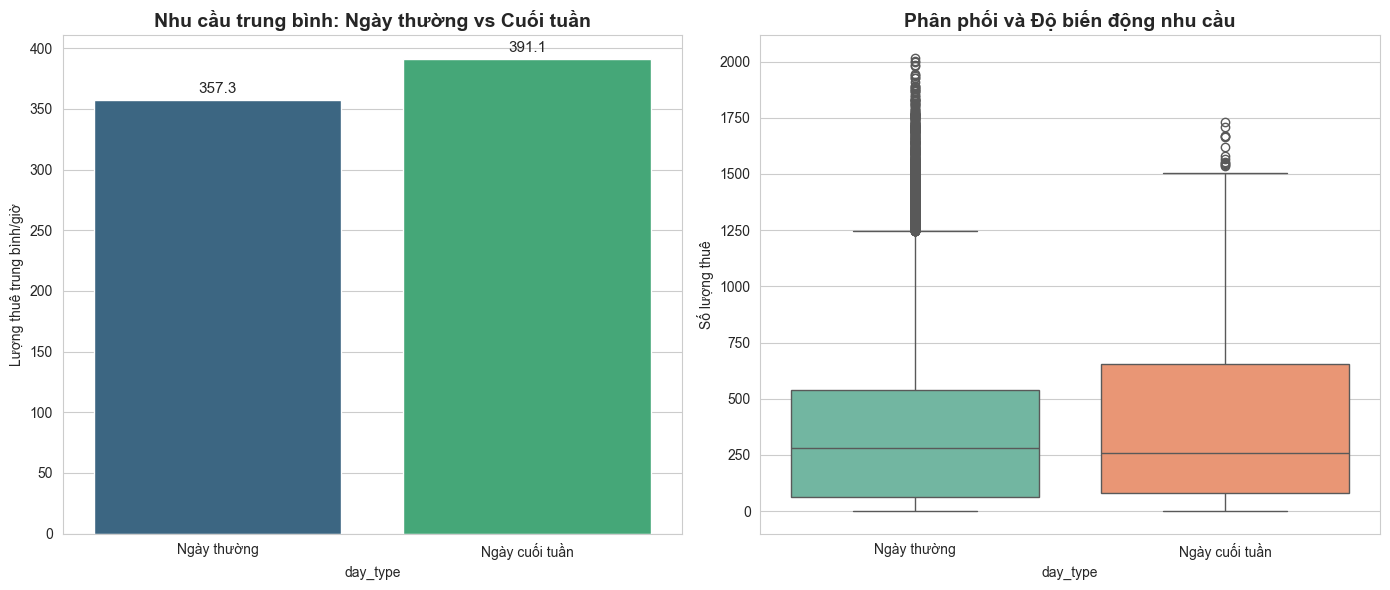

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_complete['total_rental'] = pd.to_numeric(df_complete['total_rental'], errors='coerce').fillna(0)
df_complete['day_type'] = df_complete['day_type'].astype(str)

# 2. TÍNH BẢNG THỐNG KÊ CHI TIẾT
# Chúng ta sẽ xem: Tổng, Trung bình, Trung vị (Median), và Độ lệch chuẩn (Std)
stats_day_type = df_complete.groupby('day_type')['total_rental'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index()

# Sắp xếp theo trung bình để dễ so sánh
stats_day_type = stats_day_type.sort_values(by='Trung_binh', ascending=False)

print("=== BẢNG THỐNG KÊ NHU CẦU THEO LOẠI NGÀY ===")
print(stats_day_type)
print("-" * 60)

# 3. VẼ BIỂU ĐỒ SO SÁNH (2 HÌNH)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Hình 1: Barplot (So sánh giá trị Trung bình)
sns.barplot(data=df_complete, x='day_type', y='total_rental', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
ax[0].set_title('Nhu cầu trung bình: Ngày thường vs Cuối tuần', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Lượng thuê trung bình/giờ')
# Hiển thị số lên đầu cột
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# Hình 2: Boxplot (So sánh Phân phối & Outlier)
# Hình này quan trọng để xem ngày nào nhu cầu biến động mạnh hơn
sns.boxplot(data=df_complete, x='day_type', y='total_rental', ax=ax[1], palette='Set2')
ax[1].set_title('Phân phối và Độ biến động nhu cầu', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Số lượng thuê')

plt.tight_layout()
plt.show()

## Thống kê total_rental và Day of week

=== BẢNG THỐNG KÊ NHU CẦU THEO THỨ (DOW) ===
         dow  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  \
2   saturday          5447         2280357      418.64    296.00   
0     friday          5440         1996181      366.95    301.00   
4   thursday          5414         1976716      365.11    294.00   
6  wednesday          5409         1972921      364.75    288.00   
3     sunday          5417         1968505      363.39    228.00   
5    tuesday          5406         1947218      360.20    283.00   
1     monday          5418         1786225      329.68    252.00   

   Do_lech_chuan  Cao_nhat  
2         377.57      1732  
0         325.49      1851  
4         350.67      1980  
6         355.94      1997  
3         347.37      1708  
5         356.11      2016  
1         317.83      1724  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\982168465.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_complete, x='dow', y='total_rental', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\982168465.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_complete, x='dow', y='total_rental', ax=ax[1], palette='Set2')


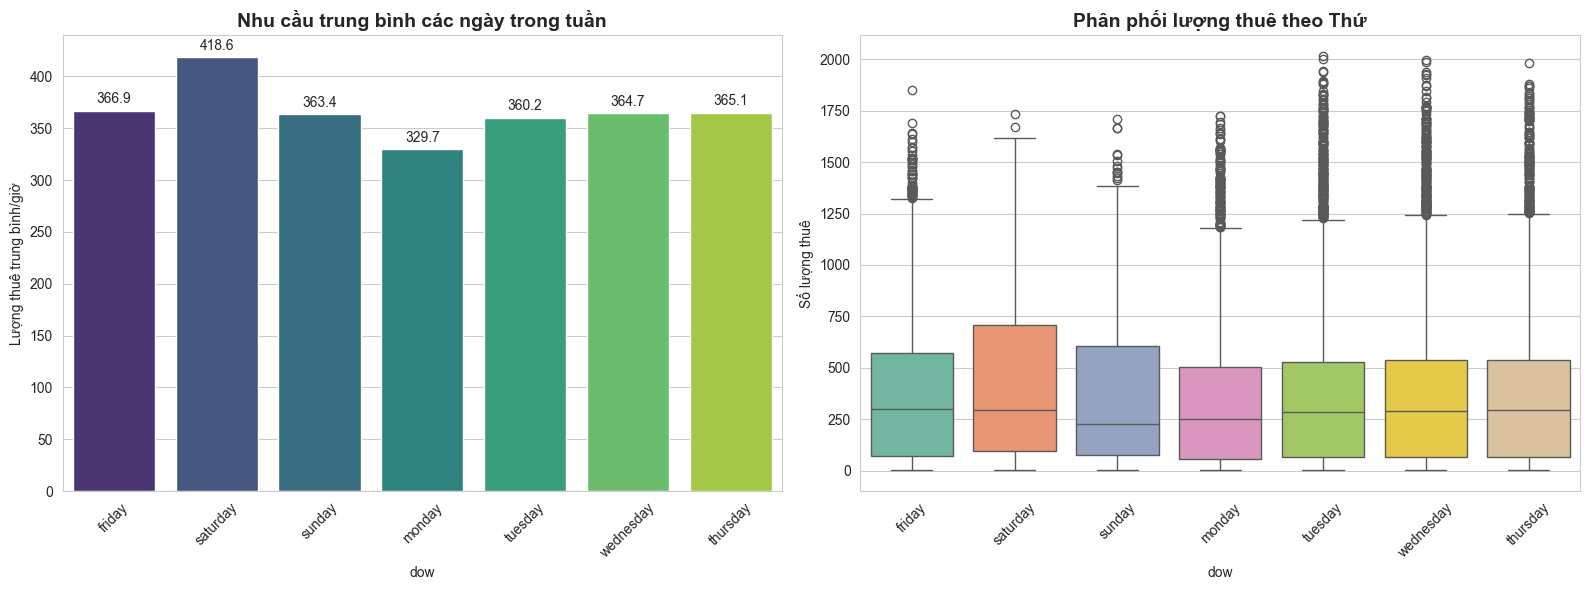

In [54]:
#1. CHUẨN BỊ DỮ LIỆU
# Đảm bảo total_rental là số
df_complete['total_rental'] = pd.to_numeric(df_complete['total_rental'], errors='coerce').fillna(0)

# Định nghĩa thứ tự đúng của các thứ trong tuần
# (Bạn kiểm tra xem dữ liệu của mình là Tiếng Anh hay Tiếng Việt để sửa list này nhé)
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Kiểm tra xem dữ liệu trong cột 'dow' có khớp với list trên không
unique_days = df_complete['dow'].unique()
# Nếu dữ liệu là số (0-6) hoặc tên khác, ta sẽ không ép kiểu category để tránh lỗi NaN
if set(unique_days).issubset(set(order_of_days)):
    df_complete['dow'] = pd.Categorical(df_complete['dow'], categories=order_of_days, ordered=True)

# 2. TÍNH BẢNG THỐNG KÊ CHI TIẾT
stats_dow = df_complete.groupby('dow')['total_rental'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index() # reset_index để đưa 'dow' thành cột, tiện cho việc vẽ


if not set(unique_days).issubset(set(order_of_days)):
    stats_dow = stats_dow.sort_values(by='Trung_binh', ascending=False)

print("=== BẢNG THỐNG KÊ NHU CẦU THEO THỨ (DOW) ===")
print(stats_dow)
print("-" * 60)

# 3. VẼ BIỂU ĐỒ (2 HÌNH)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Hình 1: Barplot (Trung bình)
sns.barplot(data=df_complete, x='dow', y='total_rental', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
ax[0].set_title('Nhu cầu trung bình các ngày trong tuần', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Lượng thuê trung bình/giờ')
ax[0].tick_params(axis='x', rotation=45) # Xoay chữ cho dễ đọc

# Hiện số lên đầu cột
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=10)

# Hình 2: Boxplot (Phân phối)
sns.boxplot(data=df_complete, x='dow', y='total_rental', ax=ax[1], palette='Set2')
ax[1].set_title('Phân phối lượng thuê theo Thứ', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Số lượng thuê')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Thống kê total_rental và season 

=== BẢNG THỐNG KÊ NHU CẦU THEO MÙA ===
   season  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  Do_lech_chuan  \
0  autumn          9575         4161551      434.63    368.00         371.68   
1  spring          8535         2847739      333.65    233.00         335.65   
2  summer         11029         4811852      436.29    367.00         375.11   
3  winter          8812         2106981      239.10    170.00         244.30   

   Cao_nhat  
0      2016  
1      1980  
2      1985  
3      1590  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\1227888846.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_complete, x='season', y='total_rental', ax=ax[0], palette='Spectral', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\1227888846.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_complete, x='season', y='total_rental', ax=ax[1], palette='Spectral')


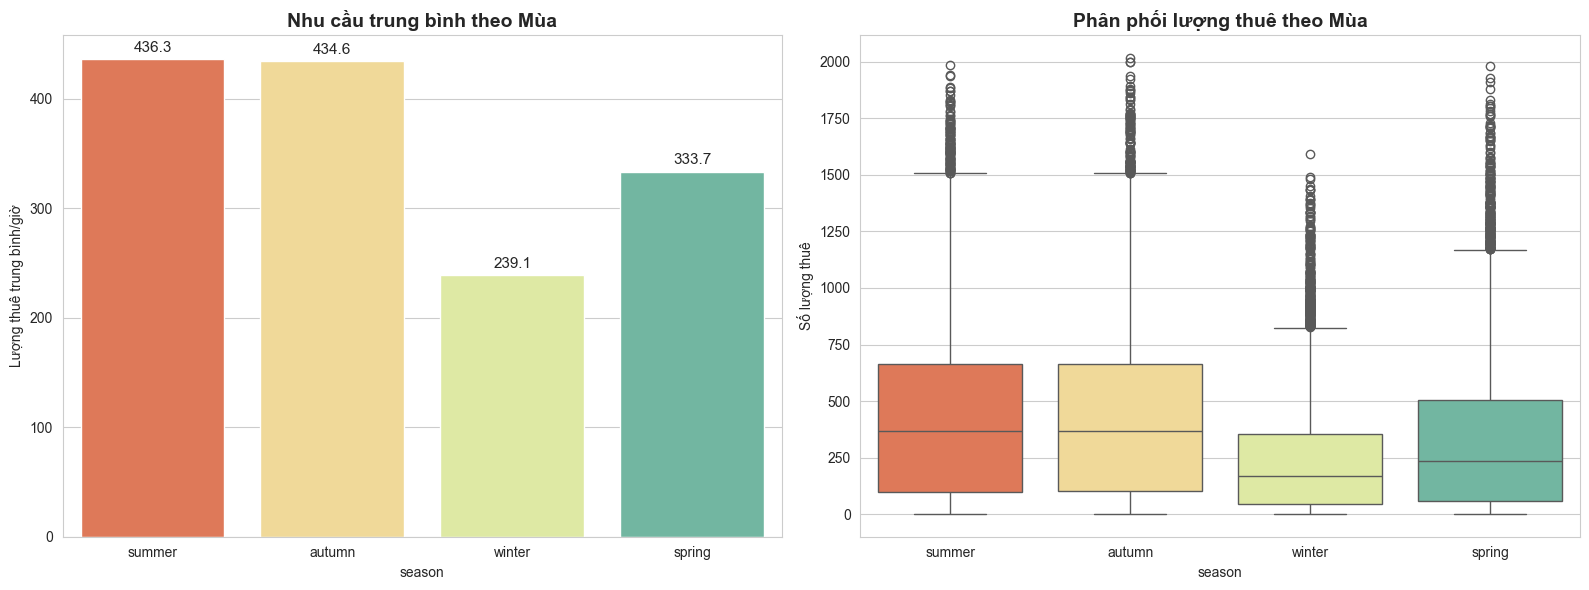

In [56]:
# 1. THIẾT LẬP THỨ TỰ MÙA (QUAN TRỌNG)
# Để biểu đồ vẽ đúng trình tự thời gian thay vì Alphabet
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Kiểm tra xem dữ liệu của bạn có đúng tên tiếng Anh như trên không
# Nếu dữ liệu dùng số (1,2,3,4) hoặc tiếng Việt, code sẽ tự bỏ qua bước sắp xếp này
if set(df_complete['season'].unique()).issubset(set(season_order)):
    df_complete['season'] = pd.Categorical(df_complete['season'], categories=season_order, ordered=True)

# 2. TÍNH BẢNG THỐNG KÊ CHI TIẾT
stats_season = df_complete.groupby('season')['total_rental'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index()

print("=== BẢNG THỐNG KÊ NHU CẦU THEO MÙA ===")
print(stats_season)
print("-" * 60)

# 3. VẼ BIỂU ĐỒ (2 HÌNH)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Hình 1: Barplot (Trung bình)
# Dùng palette màu nóng lạnh để thể hiện nhiệt độ (Coolwarm hoặc Spectral)
sns.barplot(data=df_complete, x='season', y='total_rental', ax=ax[0], palette='Spectral', estimator='mean', errorbar=None)
ax[0].set_title('Nhu cầu trung bình theo Mùa', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Lượng thuê trung bình/giờ')

# Hiện số lên đầu cột
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# Hình 2: Boxplot (Phân phối)
sns.boxplot(data=df_complete, x='season', y='total_rental', ax=ax[1], palette='Spectral')
ax[1].set_title('Phân phối lượng thuê theo Mùa', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Số lượng thuê')

plt.tight_layout()
plt.show()

## Thống kê total_rental và group_time

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2401168531.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_time = df_complete.groupby('group_time')['total_rental'].agg(
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2401168531.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_complete, x='group_time', y='total_rental', ax=ax[0], palette='Reds_r', estimator='mean', errorbar=None)


=== BẢNG THỐNG KÊ NHU CẦU THEO NHÓM GIỜ ===
     group_time  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  \
0  Giờ cao điểm          6336         3961594      625.25    548.00   
1    Giờ thường         12671         6676085      526.88    482.00   
2     Ngoài giờ         18944         3290444      173.69     78.00   

   Do_lech_chuan  Cao_nhat  
0         433.43      2016  
1         282.62      1732  
2         224.60      1464  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2401168531.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_complete, x='group_time', y='total_rental', ax=ax[1], palette='Reds_r')


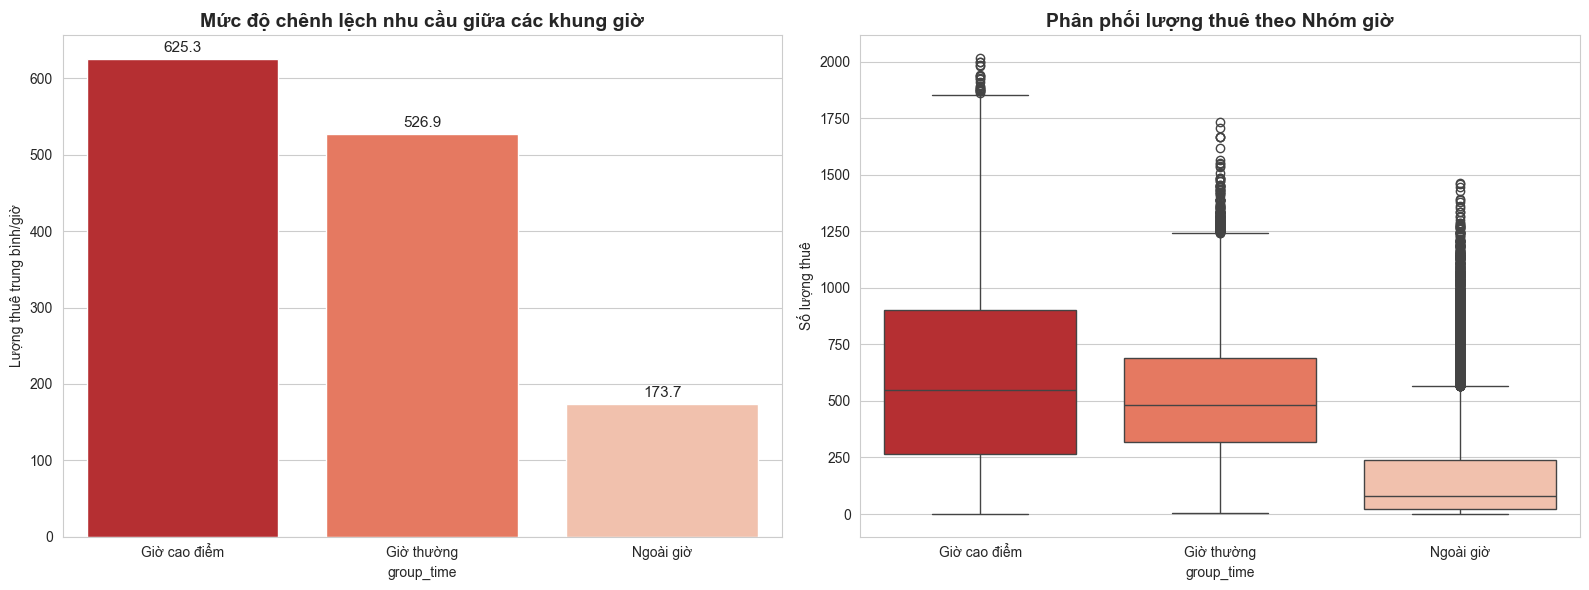

In [57]:
# 1. THIẾT LẬP THỨ TỰ HIỂN THỊ (Logical Order)
# Sắp xếp từ quan trọng nhất đến ít quan trọng nhất
time_order = ['Giờ cao điểm', 'Giờ thường', 'Ngoài giờ']

# Kiểm tra xem dữ liệu có khớp tên không để ép kiểu
if set(df_complete['group_time'].unique()).issubset(set(time_order)):
    df_complete['group_time'] = pd.Categorical(df_complete['group_time'], categories=time_order, ordered=True)

# 2. TÍNH BẢNG THỐNG KÊ CHI TIẾT
stats_time = df_complete.groupby('group_time')['total_rental'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index()

print("=== BẢNG THỐNG KÊ NHU CẦU THEO NHÓM GIỜ ===")
print(stats_time)
print("-" * 60)

# 3. VẼ BIỂU ĐỒ (2 HÌNH)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Hình 1: Barplot (Trung bình)
# Dùng palette 'Reds_r' (Đỏ đậm -> Nhạt) để nhấn mạnh sự cấp thiết của Giờ cao điểm
sns.barplot(data=df_complete, x='group_time', y='total_rental', ax=ax[0], palette='Reds_r', estimator='mean', errorbar=None)
ax[0].set_title('Mức độ chênh lệch nhu cầu giữa các khung giờ', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Lượng thuê trung bình/giờ')

# Hiện số lên đầu cột
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# Hình 2: Boxplot (Phân phối)
sns.boxplot(data=df_complete, x='group_time', y='total_rental', ax=ax[1], palette='Reds_r')
ax[1].set_title('Phân phối lượng thuê theo Nhóm giờ', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Số lượng thuê')

plt.tight_layout()
plt.show()

--- 1. PHÂN TÍCH ĐƠN BIẾN ---


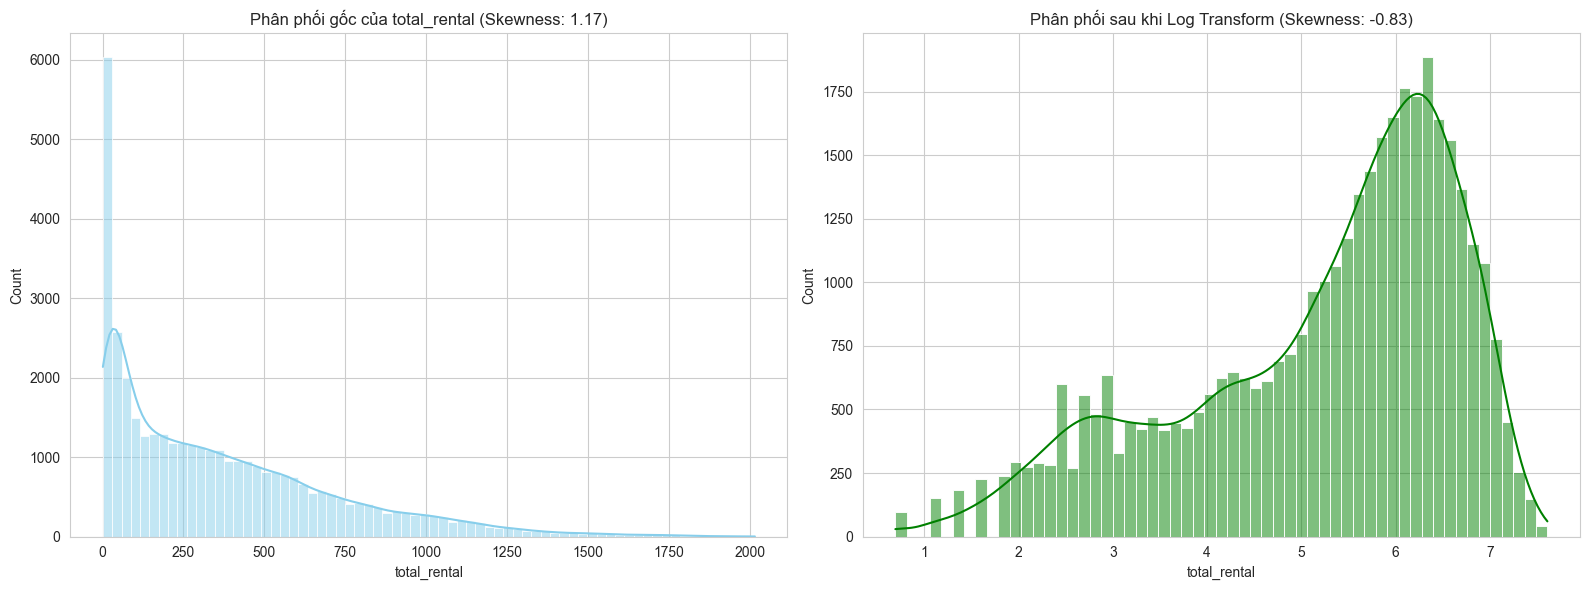

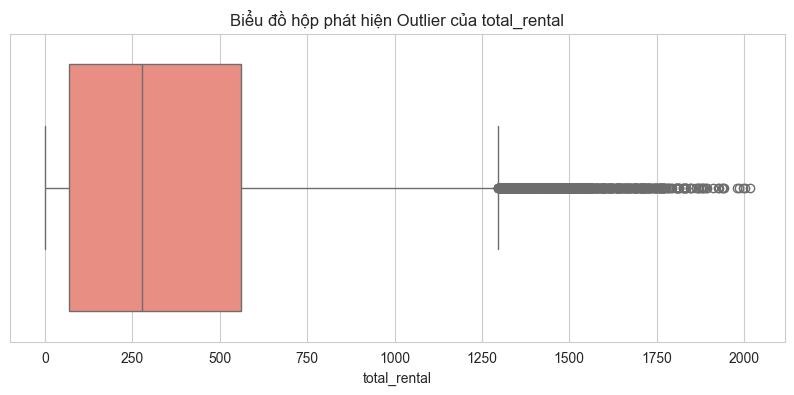

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2111794149.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_complete, x=col, ax=axes[i], palette='Set2')


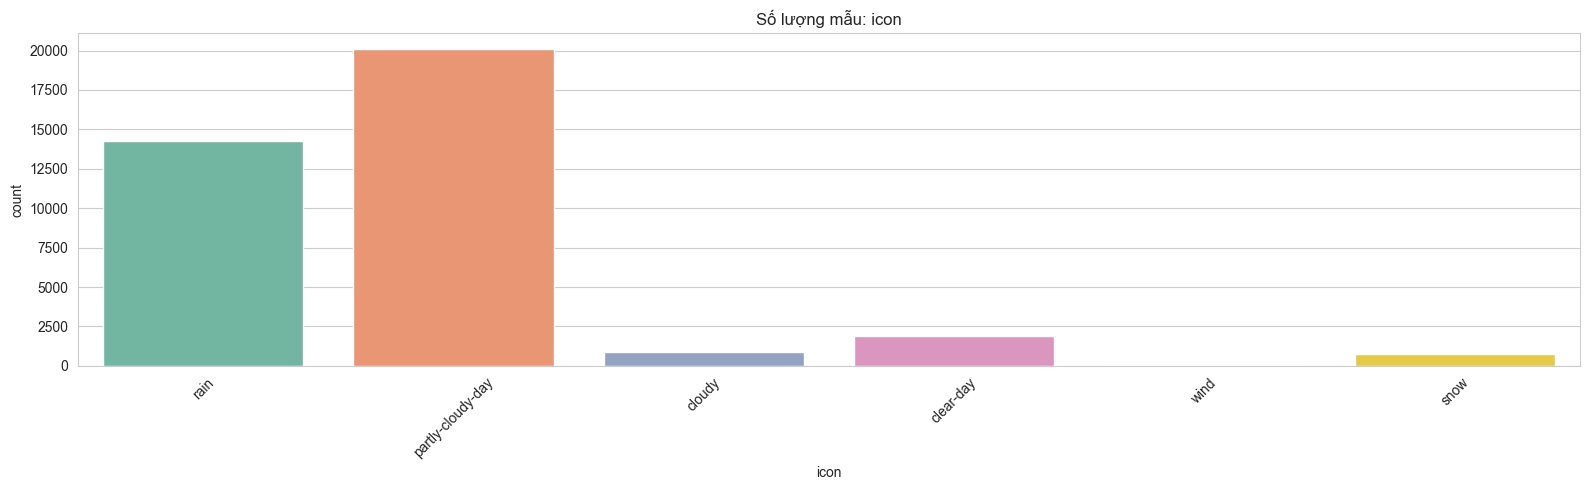

--- 2. PHÂN TÍCH HAI BIẾN (HÀNH VI & XU HƯỚNG) ---


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2111794149.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_complete, x='hour', y=target_col, hue='day_type',


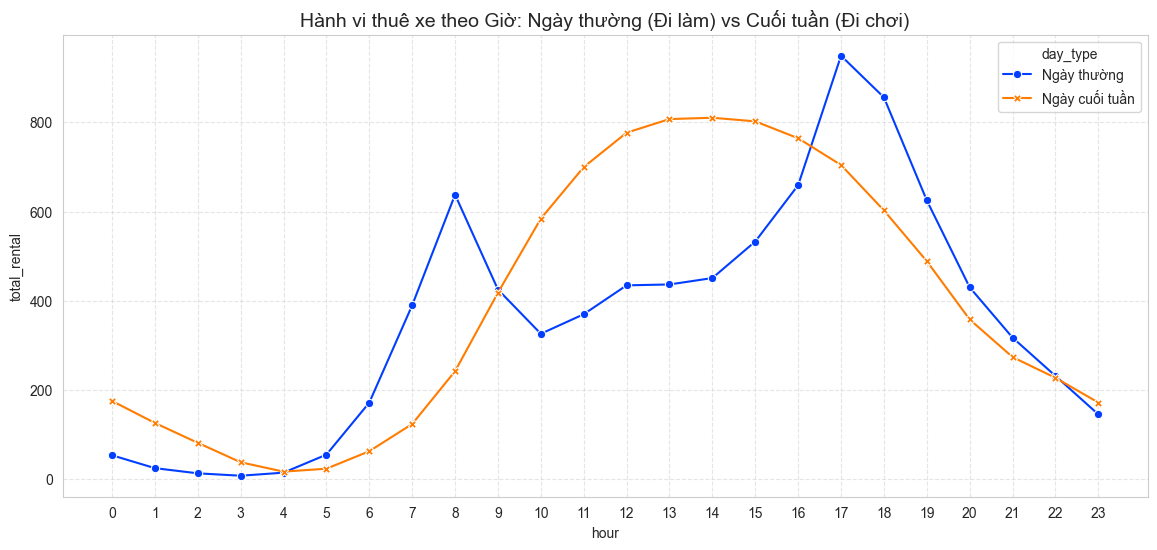

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2111794149.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_complete, x='month', y=target_col, palette='viridis', ci=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2111794149.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_complete, x='month', y=target_col, palette='viridis', ci=None)


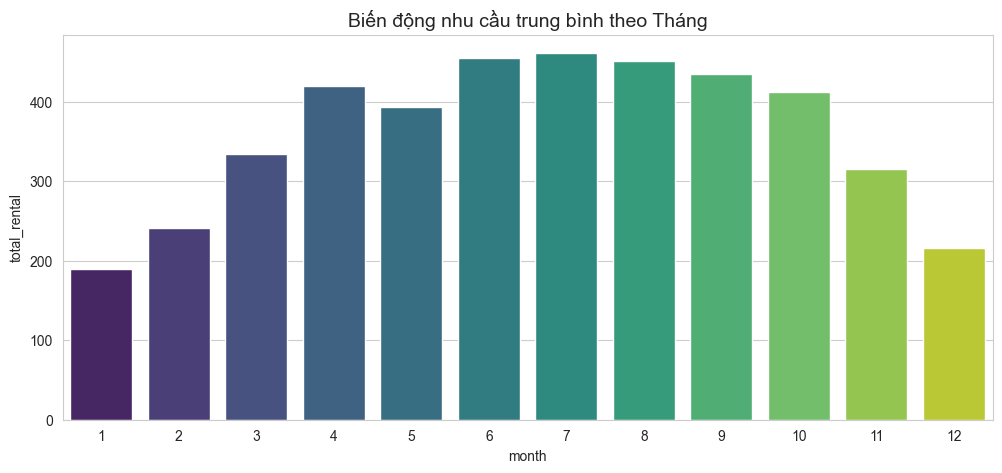

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_28260\2111794149.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_complete, x='icon', y=target_col, order=order_icon, palette='coolwarm')


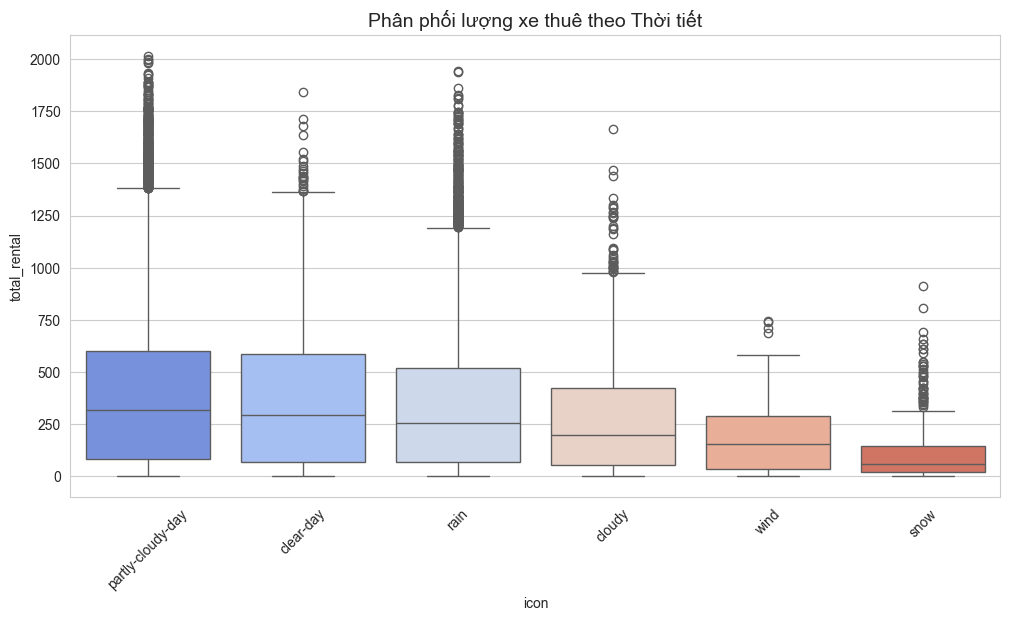

--- 3. PHÂN TÍCH ĐA BIẾN (TƯƠNG QUAN) ---


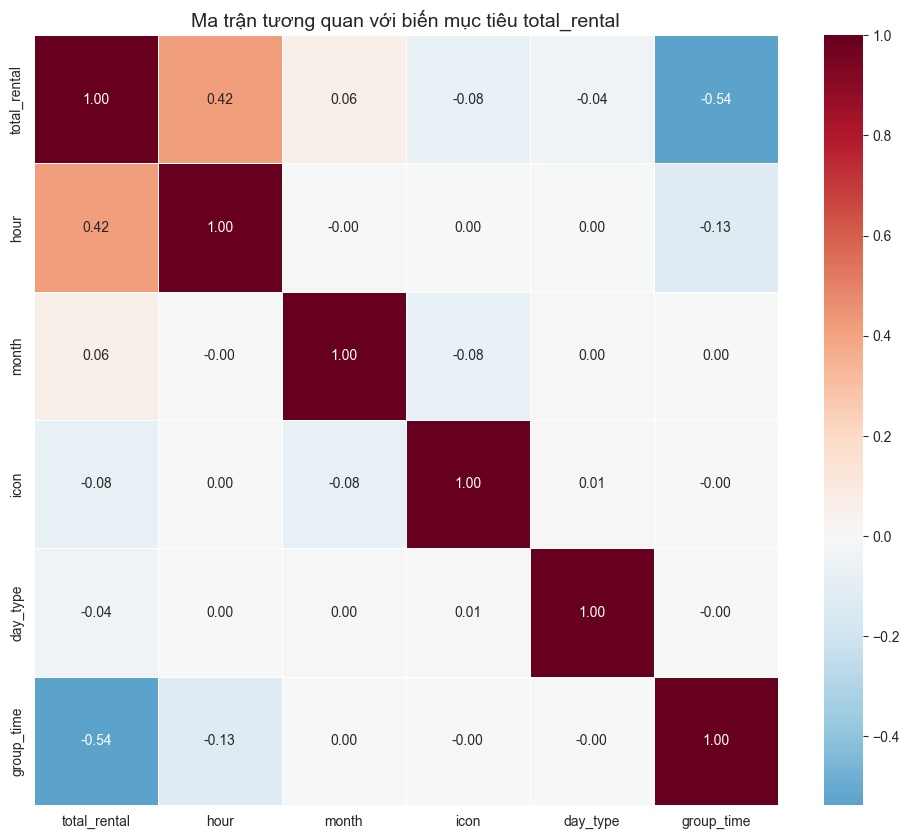

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- CẤU HÌNH BAN ĐẦU ---
sns.set_style("whitegrid") # Giao diện nền trắng kẻ lưới
plt.rcParams['figure.figsize'] = (12, 6) # Kích thước mặc định

# QUAN TRỌNG: Đặt tên biến mục tiêu bạn muốn phân tích ở đây
target_col = 'total_rental' 

# Kiểm tra xem cột có tồn tại không để tránh lỗi
if target_col not in df_complete.columns:
    print(f"Cảnh báo: Không thấy cột '{target_col}'. Đang dùng cột đầu tiên dạng số để thay thế demo.")
    target_col = df_complete.select_dtypes(include=np.number).columns[0]


# ==============================================================================
# PHẦN 1: PHÂN TÍCH ĐƠN BIẾN (UNIVARIATE ANALYSIS)
# Mục tiêu: Kiểm tra độ chuẩn (Normality) và độ cân bằng dữ liệu
# ==============================================================================
print("--- 1. PHÂN TÍCH ĐƠN BIẾN ---")

# 1.1. Kiểm tra phân phối của biến mục tiêu (Histogram & KDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ gốc
sns.histplot(df_complete[target_col], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Phân phối gốc của {target_col} (Skewness: {df_complete[target_col].skew():.2f})')

# Biểu đồ sau khi Log Transform (Để kiểm tra xem có chuẩn hơn không)
# np.log1p là log(x+1) để tránh lỗi số 0
sns.histplot(np.log1p(df_complete[target_col]), kde=True, ax=axes[1], color='green')
axes[1].set_title(f'Phân phối sau khi Log Transform (Skewness: {np.log1p(df_complete[target_col]).skew():.2f})')

plt.tight_layout()
plt.show()

# 1.2. Kiểm tra Outlier (Boxplot)
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_complete[target_col], color='salmon')
plt.title(f'Biểu đồ hộp phát hiện Outlier của {target_col}')
plt.show()

# 1.3. Kiểm tra độ cân bằng của các biến phân loại (Categorical Balance)
cols_cat = ['icon', 'day_type', 'group_time'] # Các cột chữ cần kiểm tra
cols_cat = [c for c in cols_cat if c in df_final.columns]

if cols_cat:
    fig, axes = plt.subplots(1, len(cols_cat), figsize=(16, 5))
    if len(cols_cat) == 1: axes = [axes] # Xử lý trường hợp chỉ có 1 cột
    
    for i, col in enumerate(cols_cat):
        sns.countplot(data=df_complete, x=col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'Số lượng mẫu: {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# PHẦN 2: PHÂN TÍCH HAI BIẾN (BIVARIATE ANALYSIS) - TRẢ LỜI RQ2
# Mục tiêu: Tìm hiểu hành vi khách hàng theo thời gian và ngoại cảnh
# ==============================================================================
print("--- 2. PHÂN TÍCH HAI BIẾN (HÀNH VI & XU HƯỚNG) ---")

# 2.1. Xu hướng thuê xe theo Giờ: So sánh Ngày thường vs Cuối tuần
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_complete, x='hour', y=target_col, hue='day_type', 
             style='day_type', markers=True, dashes=False, palette='bright', ci=None)
plt.title('Hành vi thuê xe theo Giờ: Ngày thường (Đi làm) vs Cuối tuần (Đi chơi)', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2.2. Xu hướng theo Tháng (Tính mùa vụ)
# Tạo cột tháng nếu chưa có
if 'month' not in df_complete.columns and 'datetime' in df_complete.columns:
    df_complete['datetime'] = pd.to_datetime(df_complete['datetime'])
    df_complete['month'] = df_complete['datetime'].dt.month

if 'month' in df_complete.columns:
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df_complete, x='month', y=target_col, palette='viridis', ci=None)
    plt.title('Biến động nhu cầu trung bình theo Tháng', fontsize=14)
    plt.show()

# 2.3. Tác động của Thời tiết (Boxplot)
if 'icon' in df_complete.columns:
    plt.figure(figsize=(12, 6))
    # Sắp xếp theo trung bình giảm dần để dễ nhìn
    order_icon = df_complete.groupby('icon')[target_col].mean().sort_values(ascending=False).index
    sns.boxplot(data=df_complete, x='icon', y=target_col, order=order_icon, palette='coolwarm')
    plt.title('Phân phối lượng xe thuê theo Thời tiết', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# ==============================================================================
# PHẦN 3: PHÂN TÍCH ĐA BIẾN (MULTIVARIATE ANALYSIS) - TRẢ LỜI RQ1
# Mục tiêu: Đánh giá độ chính xác tiềm năng (Tương quan)
# ==============================================================================
print("--- 3. PHÂN TÍCH ĐA BIẾN (TƯƠNG QUAN) ---")

# 3.1. Mã hóa dữ liệu (Encoding) để vẽ Heatmap full
df_corr = df_complete.copy()
categorical_cols = df_corr.select_dtypes(include=['object', 'category']).columns

# Chuyển chữ thành số
for col in categorical_cols:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# 3.2. Vẽ Heatmap
# Chỉ lấy các cột quan trọng
cols_to_plot = [target_col, 'hour', 'month', 'icon', 'day_type', 'group_time', 'temp', 'humidity']
# Lọc những cột thực sự có trong bảng
cols_to_plot = [c for c in cols_to_plot if c in df_corr.columns]

plt.figure(figsize=(12, 10))
correlation = df_corr[cols_to_plot].corr()

# Vẽ Heatmap
sns.heatmap(correlation, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5)
plt.title(f'Ma trận tương quan với biến mục tiêu {target_col}', fontsize=14)
plt.show()



# 6. Data Pre-processing

In [59]:
import pandas as pd
import numpy as np

# 1. Sắp xếp lại theo thời gian (BẮT BUỘC cho bài toán chuỗi thời gian)
df_model = df_complete.sort_values(by=['datetime', 'hour']).copy()

# 2. Xử lý Biến mục tiêu (Target Transformation)
# Vì EDA cho thấy dữ liệu bị lệch phải (Skewed), ta dùng Log để nắn về dạng chuẩn
# Dùng log1p (log(x+1)) để tránh lỗi log(0)
df_model['target_log'] = np.log1p(df_model['total_rental'])

print("✅ Đã Log Transform biến mục tiêu.")

# 3. Tạo Lag Features (Biến trễ) - VŨ KHÍ BÍ MẬT
# Logic: Nhu cầu lúc 8h sáng nay thường giống 8h sáng hôm qua.
# Lag 1: Nhu cầu của 1 giờ trước
df_model['lag_1h'] = df_model['total_rental'].shift(1)
# Lag 24: Nhu cầu của đúng giờ này ngày hôm qua (Quan trọng nhất)
df_model['lag_24h'] = df_model['total_rental'].shift(24)

# 4. Tạo Rolling Window Features (Trung bình trượt)
# Logic: Xu hướng trung bình của 7 ngày qua
df_model['rolling_mean_7d'] = df_model['total_rental'].rolling(window=24*7).mean()

# 5. Xử lý dữ liệu bị khuyết do tạo Lag (Shift sẽ sinh ra NaN ở đầu)
# Ta xóa các dòng đầu tiên bị NaN này
df_model = df_model.dropna()

print(f"✅ Đã tạo Lag Features. Kích thước dữ liệu hiện tại: {df_model.shape}")

✅ Đã Log Transform biến mục tiêu.
✅ Đã tạo Lag Features. Kích thước dữ liệu hiện tại: (37784, 15)


In [ ]:
# Chọn các biến cần mã hóa
categorical_cols = ['season', 'day_type', 'group_time', 'dow', 'icon']

# Đảm bảo các cột này có trong bảng
valid_cat_cols = [c for c in categorical_cols if c in df_model.columns]

# Dùng pd.get_dummies để One-Hot Encoding
# drop_first=True để tránh đa cộng tuyến (Dummy Trap) - Ví dụ: Có cột Nam thì không cần cột Nữ
df_model = pd.get_dummies(df_model, columns=valid_cat_cols, drop_first=True)

print("✅ Đã mã hóa One-Hot Encoding.")
print("Các cột hiện có:", df_model.columns.tolist())

✅ Đã mã hóa One-Hot Encoding.
Các cột hiện có: ['datetime', 'hour', 'total_rental', 'ride_id', 'started_at', 'month', 'target_log', 'lag_1h', 'lag_24h', 'rolling_mean_7d', 'season_spring', 'season_summer', 'season_winter', 'day_type_Ngày thường', 'group_time_Giờ thường', 'group_time_Ngoài giờ', 'dow_monday', 'dow_saturday', 'dow_sunday', 'dow_thursday', 'dow_tuesday', 'dow_wednesday', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain', 'icon_snow', 'icon_wind']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Sắp xếp lại theo thời gian để chắc chắn quá khứ nằm trước
df_model = df_model.sort_values(by=['datetime', 'hour'])

# Xác định biến đầu vào (X) và biến mục tiêu (y)
# Loại bỏ các cột không dùng để train
cols_drop = ['total_rental', 'datetime', 'started_at', 'target_log', 'ride_id']
cols_drop = [c for c in cols_drop if c in df_model.columns]

X = df_model.drop(columns=cols_drop)
y = df_model['target_log'] # Dự báo trên log để chuẩn xác hơn

# --- 2. TÍNH TOÁN ĐIỂM CẮT (SPLIT INDICES) ---
# Tỷ lệ chia: 70% Train - 15% Val - 15% Test
n = len(df_model)
train_end = int(n * 0.70)          # Điểm kết thúc Train
val_end = int(n * 0.85)            # Điểm kết thúc Val (70% + 15%)

# --- 3. THỰC HIỆN CẮT (SLICING) ---
# Tập Train
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

# Tập Validation
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

# Tập Test
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"--- KÍCH THƯỚC CÁC TẬP DỮ LIỆU ---")
print(f"1. Train Set: {X_train.shape[0]} dòng (Từ {df_model.iloc[0]['datetime']} đến {df_model.iloc[train_end-1]['datetime']})")
print(f"2. Val Set:   {X_val.shape[0]} dòng (Từ {df_model.iloc[train_end]['datetime']} đến {df_model.iloc[val_end-1]['datetime']})")
print(f"3. Test Set:  {X_test.shape[0]} dòng (Từ {df_model.iloc[val_end]['datetime']} đến {df_model.iloc[-1]['datetime']})")

# --- 4. CHUẨN HÓA DỮ LIỆU (SCALING) ---
# QUAN TRỌNG: Chỉ 'fit' (học quy luật) trên tập Train, sau đó áp dụng cho Val và Test
# Để đảm bảo mô hình không 'nhìn thấy' trước dữ liệu tương lai
scaler = StandardScaler()

# Fit và Transform Train
X_train_scaled = scaler.fit_transform(X_train)

# Chỉ Transform Val và Test (Dùng quy luật của Train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Chuyển lại thành DataFrame (để giữ tên cột cho dễ nhìn sau này)
X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_final = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


--- KÍCH THƯỚC CÁC TẬP DỮ LIỆU ---
1. Train Set: 26448 dòng (Từ 2020-05-08 00:00:00 đến 2023-05-17 00:00:00)
2. Val Set:   5668 dòng (Từ 2023-05-17 00:00:00 đến 2024-01-08 00:00:00)
3. Test Set:  5668 dòng (Từ 2024-01-08 00:00:00 đến 2024-08-31 00:00:00)

✅ Đã chia tập và chuẩn hóa xong. Sẵn sàng training!


# 7.Xây dựng & Huấn luyện Model

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Tạo bảng để lưu kết quả so sánh
model_performance = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2_Score'])

def evaluate_model(model, X_val, y_val, model_name):
    # 1. Dự báo (Kết quả vẫn đang ở dạng Log)
    pred_log = model.predict(X_val)
    
    # 2. Nghịch đảo Log để về số lượng xe thực tế (Dùng np.expm1 vì lúc trước dùng np.log1p)
    pred_real = np.expm1(pred_log)
    y_true_real = np.expm1(y_val)
    
    # 3. Tính toán sai số
    rmse = np.sqrt(mean_squared_error(y_true_real, pred_real))
    mae = mean_absolute_error(y_true_real, pred_real)
    r2 = r2_score(y_true_real, pred_real)
    
    print(f"--- Đánh giá mô hình: {model_name} ---")
    print(f"RMSE (Sai số trung bình phương): {rmse:.2f}")
    print(f"MAE  (Sai số tuyệt đối):        {mae:.2f}")
    print(f"R2   (Độ phù hợp):              {r2:.4f}")
    print("-" * 40)
    
    # Lưu vào bảng so sánh
    global model_performance
    new_row = pd.DataFrame({'Model': [model_name], 'RMSE': [rmse], 'MAE': [mae], 'R2_Score': [r2]})
    model_performance = pd.concat([model_performance, new_row], ignore_index=True)
    
    return pred_real